In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import pymc3 as pm

In [43]:
# Add truth idicator to edges
# Add how many intermediates for indirect

# Add hpd for num unobserved:
# import arviz as az
# az.hdi(val)
# val = n_unobserved_transmissions.loc[:,"12_24"].values
# val = val[~np.isnan(val)]


In [105]:
DECIMAL_PRECISION = 2
PROBABILITY_THRESHOLD = 0.2
INPUT_FOLDER_PATH = '/Users/jugne/Documents/Source/TnT/validation/mapper/testing/remap/run_11/'
FILE_NAME = 'inf_SW_EC_remap_tr_analyser'
OUTPUT_FOLDER_PATH = '/Users/jugne/Documents/Source/TnT/validation/mapper/testing/remap/run_11/out/'


In [108]:
from pathlib import Path
Path(OUTPUT_FOLDER_PATH).mkdir(parents=True, exist_ok=True)

In [45]:
tnt_analyser = pd.read_csv(FOLDER_NAME+FILE_NAME+".txt",
                          sep="\t")
sim_truth_file = FOLDER_NAME+"trees_and_pars.txt"
# tnt_analyser.head()

In [46]:
# host list
hosts = np.unique([i.split('_', 1)[0] for i in tnt_analyser.columns])

In [47]:
def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

lookup_start = 'transmission times'
lookup_end = 'SA count'
start = False
end = False
from_=[]
to_=[]
time_=[]
with open(sim_truth_file) as simFile:
    for line in simFile:
        if lookup_end in line:
            end = True
        if start and not end:
            pair = line.rstrip().split(':')[0]
            from_.append(pair.split('_')[0])
            to_.append(pair.split('_')[1])
            time_.append(line.rstrip().split(':')[1])
#             lines.append(line.rstrip())
        if lookup_start in line:
            start = True
        
df_sim = pd.DataFrame({'from':from_, 'to':to_, 'time':time_})

In [48]:
# get direct transmission pairs that were sampled
from_=[]
to_=[]
tr_times_in_sampled_hosts = []
tr_times_in_sampled = []
for index in df_sim.index:
    from_val = df_sim.loc[index,'from']
    to_val = df_sim.loc[index,'to']
    if to_val in hosts:
        tr_times_in_sampled_hosts.append(to_val)
        tr_times_in_sampled.append(df_sim.loc[index,'time'])
        if from_val in hosts:
            from_.append(from_val)
            to_.append(to_val)

df_direct_tr_in_sampled = pd.DataFrame({'from':from_, 'to':to_})
df_tr_times_in_sampled = pd.DataFrame({'host':tr_times_in_sampled_hosts, 'time':tr_times_in_sampled})

In [152]:
# get indirect transmission pairs that were sampled
dict_to = dict(zip(df_sim['to'], df_sim['from']))
from_=[]
to_=[]
n_intermediate_=[]
intermediate_=[]
source=''
# root = ''
for h in hosts:
    n_int = 0
    if h=='unsampled':
        continue
    sink = h
    tmp_intermediate=[]
    
    if not h in df_direct_tr_in_sampled['to'].values:
        source = dict_to.get(sink)
        while not source in df_direct_tr_in_sampled['to'].values:
            if source not in dict_to.keys(): #or n_int >= hosts.size:
                source = 'unsampled'
#               root=source
                break
            sink = source
            source = dict_to.get(sink) 
            n_int+=1 
            tmp_intermediate.append(sink)

        from_.append(source)
        to_.append(h)
        n_intermediate_.append(n_int)
        intermediate_.append(tmp_intermediate)

intermediate_ = [' '.join(str(y) for y in x) for x in intermediate_]
df_indirect_tr_in_sampled = pd.DataFrame({'from':from_,
                                          'to':to_,
                                          'intermediate':intermediate_, 
                                          'n_intermediate':n_intermediate_})
                

In [153]:
##############################################
####### save true transmission history #######
##############################################
df_indirect_tr_in_sampled.to_csv(OUTPUT_FOLDER_PATH+'indirect_sampled_transmission.csv')
df_direct_tr_in_sampled.to_csv(OUTPUT_FOLDER_PATH+'direct_sampled_transmission.csv')

In [129]:
###################################################################
####### get probabilities of diferent kinds of transmission #######
###################################################################


# prob of direct transmission:
dd = tnt_analyser.loc[:,:]==1
prob_direct = dd.sum()/dd.shape[0]

# prob of indirect or direct transmission:
dd = tnt_analyser.loc[:,:]>=1
prob_indirectAndDirect = dd.sum()/dd.shape[0]

# prob of indirect transmission:
dd = tnt_analyser.loc[:,:]>1
prob_indirect = dd.sum()/dd.shape[0]

# prob of no transmission:
dd = tnt_analyser.loc[:,:]==0
prob_noTr = dd.sum()/dd.shape[0]

# count intermediate unobserved transmissions
n_unobserved_transmissions = tnt_analyser[tnt_analyser.loc[:,:]>=1]-1

In [145]:
##########################################
####### indirect dataframes ##############
##########################################
names_indirect = tnt_analyser.columns[prob_indirect>0]
from_indirect = [i.split('_', 1)[0] for i in names_indirect]
to_indirect = [i.split('_', 1)[1] for i in names_indirect]

edges_indirect = pd.DataFrame({'from': from_indirect, 
                               'to': to_indirect, 
                               'probability': prob_indirect[prob_indirect>0],
                               'median_unobserved': n_unobserved_transmissions.loc[:,names_indirect].median()})
nodes_indirect = pd.DataFrame({'id': np.unique([i.split('_', 1)[0] for i in from_indirect+to_indirect])})

# add edge labels, set precision
edges_indirect.loc[:, 'label'] = np.around(edges_indirect.loc[:, 'probability'],
                                           decimals=DECIMAL_PRECISION).astype(str)

###################################
######## direct dataframes ########
###################################
names_direct = tnt_analyser.columns[prob_direct>0]
from_direct = [i.split('_', 1)[0] for i in names_direct]
to_direct = [i.split('_', 1)[1] for i in names_direct]

edges_direct = pd.DataFrame({'from': from_direct, 
                             'to': to_direct, 
                             'probability': prob_direct[prob_direct>0]})
nodes_direct = pd.DataFrame({'id': np.unique([i.split('_', 1)[0] for i in from_direct+to_direct])})

# add edge labels, set precision
edges_direct.loc[:, 'label'] = np.around(edges_direct.loc[:, 'probability'],
                                         decimals=DECIMAL_PRECISION).astype(str)

###############################################################
######### direct and indirect transmission dataframes #########
###############################################################
names_indirectAndDirect = tnt_analyser.columns[prob_indirectAndDirect>0]
from_indirectAndDirect = [i.split('_', 1)[0] for i in names_indirectAndDirect]
to_indirectAndDirect = [i.split('_', 1)[1] for i in names_indirectAndDirect]

inf_intermediates = []
for name in names_indirectAndDirect:
    inf_intermediates.append(n_unobserved_transmissions[n_unobserved_transmissions[name].notnull()][name].values)
inf_intermediates = [' '.join(str(y) for y in x) for x in inf_intermediates]
    
edges_indirectAndDirect = pd.DataFrame({'from': from_indirectAndDirect, 
                                        'to': to_indirectAndDirect, 
                                        'probability': prob_indirectAndDirect[prob_indirectAndDirect>0],
                                        'n_unobserved':inf_intermediates,
                                        'median_unobserved': np.nan_to_num(n_unobserved_transmissions.loc[:,names_indirectAndDirect].median())})
nodes_indirectAndDirect = pd.DataFrame({'id': np.unique([i.split('_', 1)[0] for i in from_indirectAndDirect+to_indirectAndDirect])})

# add edge labels, set precision
edges_indirectAndDirect.loc[:, 'label'] = np.around(edges_indirectAndDirect.loc[:, 'probability'],
                                                    decimals=DECIMAL_PRECISION).astype(str)

# calculate root probability
root = [1-edges_indirectAndDirect.loc[edges_indirectAndDirect.loc[:,'to']==h,'probability'].sum() for h in nodes_indirectAndDirect['id']]
nodes_indirectAndDirect.loc[:, 'root_probability'] = np.around(root, decimals=3)

In [149]:
##################################################
####### save inferred transmission history #######
##################################################
edges_indirectAndDirect.to_csv(OUTPUT_FOLDER_PATH+'inferred_transmission.csv')

# n_unobserved_transmissions.loc[:,names_indirectAndDirect].to_csv(OUTPUT_FOLDER_PATH+'n_unobserved_transmissions.csv')

In [150]:
# Apply probability treshold fo inclusion in the graph
edges_indirectAndDirect_trh = edges_indirectAndDirect[edges_indirectAndDirect.probability > PROBABILITY_THRESHOLD]

# Build your graph. Note that we use the DiGraph function to create the graph!
G=nx.from_pandas_edgelist(edges_indirectAndDirect_trh, 'from', 'to',  ['probability', 'median_unobserved'], create_using=nx.DiGraph())
# colors = [nodes_indirectAndDirect[nodes_indirectAndDirect['id']==i]['root_probability'].item() for i in list(G.nodes)]
# col = ["None" if x <=0 else x for x in [np.around((i * 10)-1) for i in colors]]

# Node colors by root probability
cmap = mpl.cm.get_cmap("Greens")
node_col = dict(zip(nodes_indirectAndDirect.id, nodes_indirectAndDirect.root_probability))
for key, value in node_col.items():
            rgba = cmap(value)
            node_col[key] = mpl.colors.rgb2hex(rgba)


nx.set_node_attributes(G,
                       node_col,
                       "fillcolor")

# set edge width by transmission probability
nx.set_edge_attributes(G,
                       nx.get_edge_attributes(G, 'probability'),
                       "penwidth")

# merge transmission probability and mean intermediate transmissions for edge labels
dct_rounded_probs = {k: round(v, DECIMAL_PRECISION) for k, v in nx.get_edge_attributes(G, 'probability').items()} 
dct_rounded_unobserved_count = {k: round(v, DECIMAL_PRECISION) for k, v in nx.get_edge_attributes(G, 'median_unobserved').items()}
dct_label = {k: str(dct_rounded_probs[k])+', '+str(dct_rounded_unobserved_count[k]) for k in nx.get_edge_attributes(G, 'probability').keys()}

nx.set_edge_attributes(G,
                       dct_label,
                       "label")

# fig, ax = plt.subplots(figsize=(15,10))
# # Make the graph
# nx.draw(G,ax=ax, with_labels=True, 
#         pos=graphviz_layout(G,prog="dot", args='-Grankdir=LR'),#pos=nx.spiral_layout(G, equidistant=True, resolution=0.8),#pos=nx.spring_layout(G, k=20/np.sqrt(G.order())),
#         node_color=[nodes_indirectAndDirect[nodes_indirectAndDirect['id']==i]['root_probability'] for i in list(G.nodes)],
#         cmap=plt.get_cmap("Greens"), node_size=1500, node_shape='H', alpha=0.6, arrows=True, connectionstyle='Angle3')



# plt.title("Directed")
# plt.show()

In [151]:
A = nx.nx_agraph.to_agraph(G)
A.layout(prog='dot')   
A.draw(OUTPUT_FOLDER_PATH+FILE_NAME+'.png',args='-Grankdir=LR -Gsplines=true -Goverlap="false" -Nshape=hexagon -Nstyle=filled', prog='dot' ) 

# A.draw('test3.png',args='-Gnodesep=0.01 -Gfont_size=1', prog='dot' ) 
# plt.show() 

In [84]:
# from jaal import Jaal
# Jaal(edges_indirectAndDirect, nodes_indirectAndDirect).plot(directed=True)

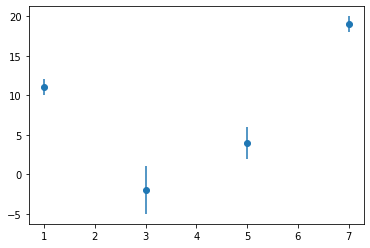

In [91]:
import matplotlib as plt
a = [1,3,5,7]
b = [11,-2,4,19]
plt.pyplot.scatter(a,b)
# plt.scatter(a,b)
# <matplotlib.collections.PathCollection object at 0x00000000057E2CF8>
# plt.pyplot.show()
c = [1,3,2,1]
plt.pyplot.errorbar(a,b,yerr=c, linestyle="None")
# <Container object of 3 artists>
plt.pyplot.show()